In [1]:
from math import pi as PI
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_1dspatial, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator1DSpatialTemporal
from neurodiffeq.temporal import Monitor1DSpatialTemporal
from neurodiffeq.temporal import _solve_1dspatial_temporal
from neurodiffeq.pde import IBVP1D, solve2D, ExampleGenerator2D, Monitor2D

In [2]:
DIFFUSIVITY, X_MIN, X_MAX, T_MIN, T_MAX = 0.3, 0.0, 2.0, 0.0, 6.0

def heat_equation_1d(u, x, t):
    return diff(u, t) - DIFFUSIVITY * diff(u, x, order=2)

def analytical_solution(xx, tt):
    return torch.sin(PI*xx/X_MAX) * torch.exp(-DIFFUSIVITY * PI**2 * tt / X_MAX**2)

def rmse(uu, xx, tt):
    error = uu - analytical_solution(xx, tt)
    return torch.mean(error**2)**0.5
metrics = {'rmse': rmse}

<IPython.core.display.Javascript object>


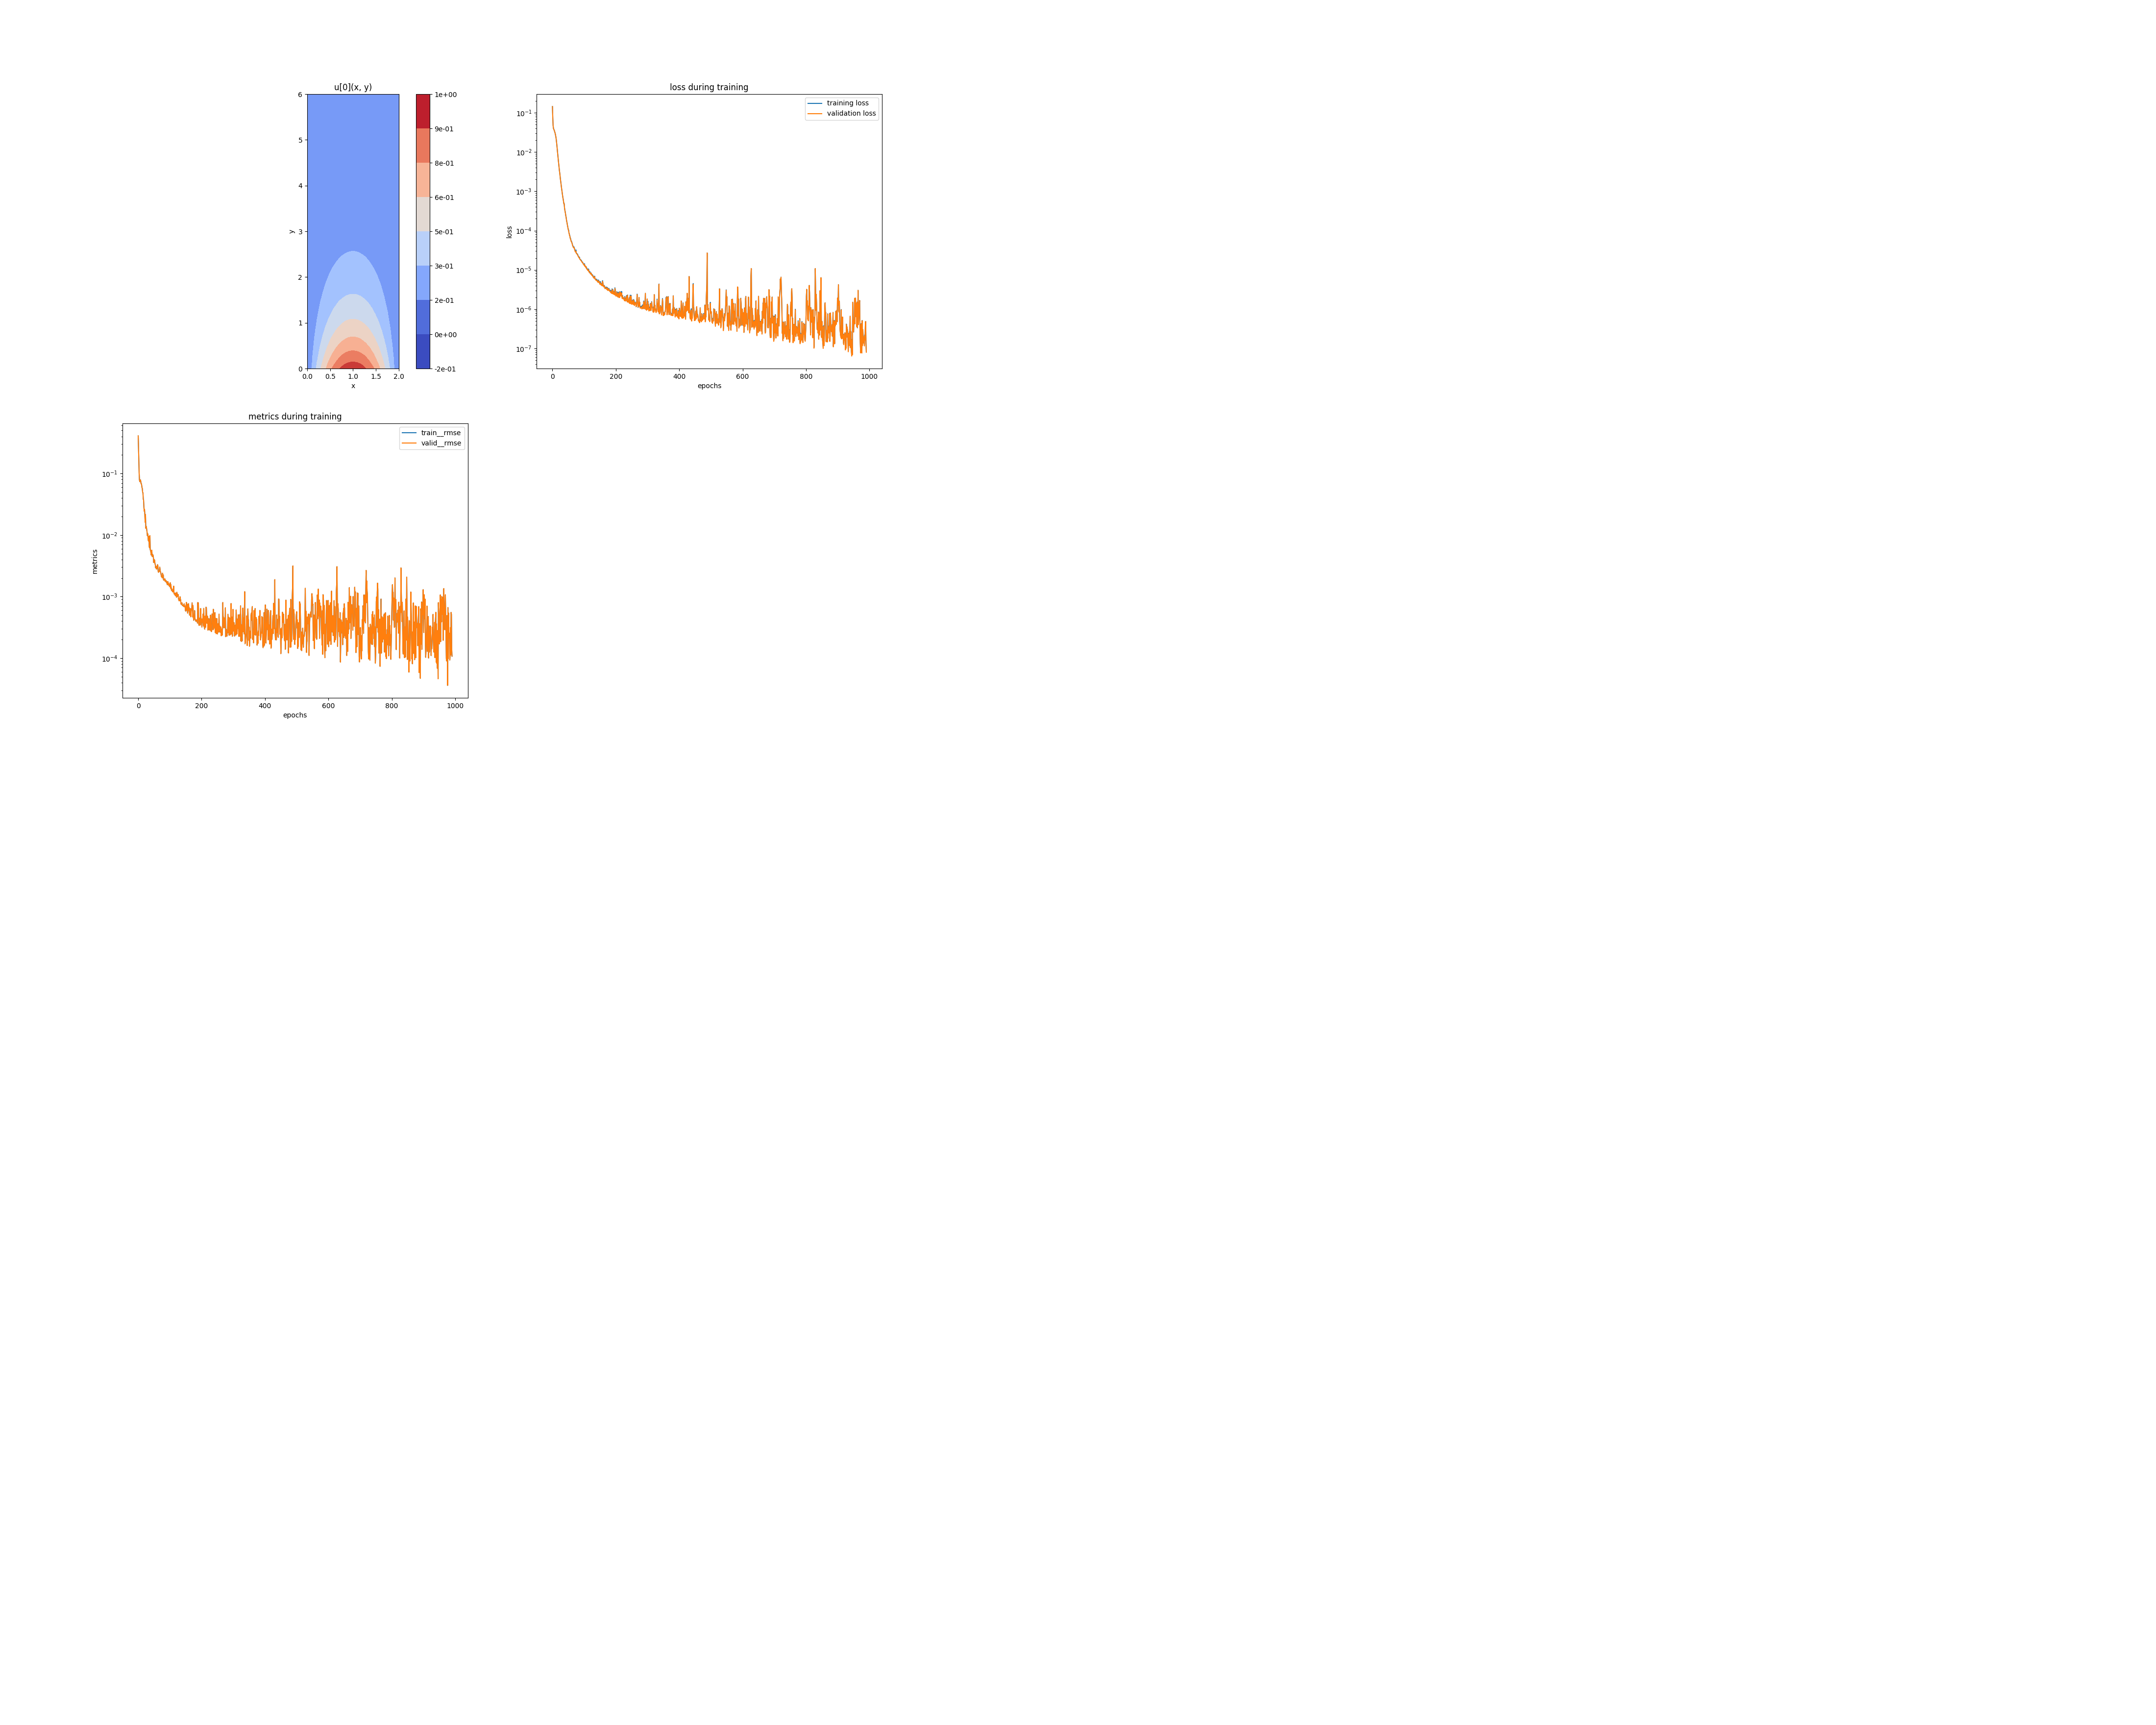

In [3]:
%matplotlib notebook
ibvp = IBVP1D(
    t_min=T_MIN, t_min_val=lambda x: torch.sin(PI*x / X_MAX),
    x_min=X_MIN, x_min_val=lambda t: 0.,
    x_max=X_MAX, x_max_val=lambda t: 0.
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)
train_gen = ExampleGenerator2D((32, 32), (X_MIN, T_MIN), (X_MAX, T_MAX), method='equally-spaced-noisy')
valid_gen = ExampleGenerator2D((32, 32), (X_MIN, T_MIN), (X_MAX, T_MAX), method='equally-spaced')
monitor = Monitor2D(check_every=10, xy_min=(X_MIN, T_MIN), xy_max=(X_MAX, T_MAX))

heat_equation_1d_solution_methodA, _ = solve2D(
    pde=heat_equation_1d, condition=ibvp, xy_min=(X_MIN, T_MIN), xy_max=(X_MAX, T_MAX),
    net=net, batch_size=64, max_epochs=1000, train_generator=train_gen, valid_generator=valid_gen,
    metrics=metrics,
    monitor=monitor
)

<IPython.core.display.Javascript object>


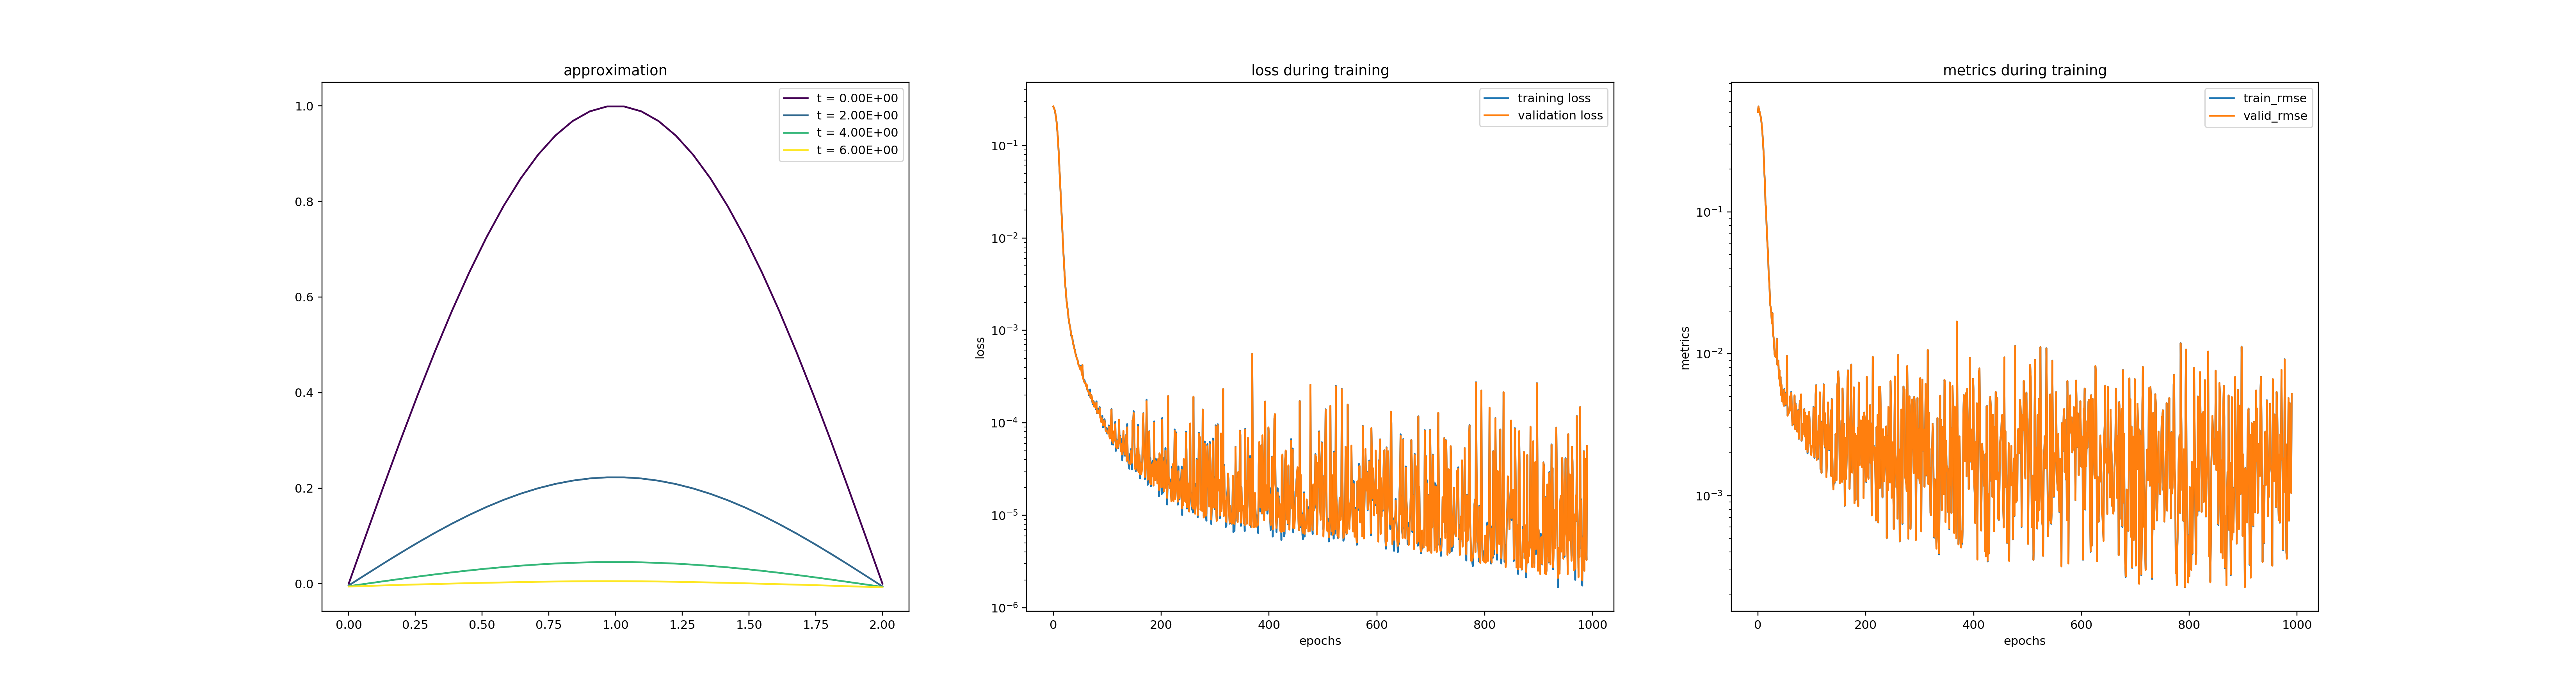

In [4]:
%matplotlib notebook
initial_condition = FirstOrderInitialCondition(u0=lambda x: torch.sin(PI*x / X_MAX))

# a generator seems too much trouble for 1D boundary, but may be more flexible for 2D boundary
def points_gen_lo():
    while True:
        yield torch.tensor([X_MIN])
dirichlet_boundary_lo = BoundaryCondition(
    form=lambda u, x, t: u,
    points_generator=points_gen_lo()
)
def points_gen_hi():
    while True:
        yield torch.tensor([X_MAX])
dirichlet_boundary_hi = BoundaryCondition(
    form=lambda u, x, t: u,
    points_generator=points_gen_hi()
)

train_gen_spatial = generator_1dspatial(size=32, x_min=X_MIN, x_max=X_MAX)
train_gen_temporal = generator_temporal(size=32, t_min=T_MIN, t_max=T_MAX)
valid_gen_spatial = generator_1dspatial(size=32, x_min=X_MIN, x_max=X_MAX, random=False)
valid_gen_temporal = generator_temporal(size=32, t_min=T_MIN, t_max=T_MAX, random=False)
monitor = Monitor1DSpatialTemporal(
    check_on_x=torch.linspace(X_MIN, X_MAX, 32),
    check_on_t=torch.linspace(T_MIN, T_MAX, 4),
    check_every=10
)

fcnn = FCNN(
        n_input_units=2,
        n_output_units=1,
        n_hidden_units=32,
        n_hidden_layers=1,
        actv=nn.Tanh
)
fcnn_approximator = SingleNetworkApproximator1DSpatialTemporal(
    single_network=fcnn,
    pde=heat_equation_1d,
    initial_condition=initial_condition,
    boundary_conditions=[dirichlet_boundary_lo, dirichlet_boundary_hi]
)
adam = optim.Adam(fcnn_approximator.parameters())

heat_equation_1d_solution_methodB, _ = _solve_1dspatial_temporal(
    train_generator_spatial=train_gen_spatial,
    train_generator_temporal=train_gen_temporal,
    valid_generator_spatial=valid_gen_spatial,
    valid_generator_temporal=valid_gen_temporal,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=64,
    max_epochs=1000,
    shuffle=True,
    metrics=metrics,
    monitor=monitor
)